In [1]:
import pandas as pd
import os
import numpy as np
import geopy
import geopandas
import matplotlib.pyplot as plt
import math
import re

# Residential Tree Planting project data prep

## Loading and formatting data

In [2]:
#Rename excel files
old_names = list(os.listdir('./data'))

for i in old_names:
    if '.xlsx' not in i or '$' in i:
        old_names.remove(i)

old_names

['boundaries',
 'fall_2023.xlsx',
 'fall_2024.xlsx',
 'fall_2025.xlsx',
 'spring_2023.xlsx',
 'spring_2024_1.xlsx',
 'spring_2024_2.xlsx',
 'spring_2025.xlsx']

In [3]:
new_names = []
for i in old_names:
    new_name = i.lower().replace(" ","_").strip()
    new_name = new_name.replace("casey_", "").replace("tree_","").replace("trees_","").replace("planting_","")
    new_names.append(new_name)

new_names

['boundaries',
 'fall_2023.xlsx',
 'fall_2024.xlsx',
 'fall_2025.xlsx',
 'spring_2023.xlsx',
 'spring_2024_1.xlsx',
 'spring_2024_2.xlsx',
 'spring_2025.xlsx']

In [4]:
# Read files into df
dfs = {}
for i in new_names:
    if 'xlsx' in i:
        dfs[i] = pd.read_excel(("./data/"+i), header=0)

C:\Users\pmedina\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [5]:
dfs.keys()

dict_keys(['fall_2023.xlsx', 'fall_2024.xlsx', 'fall_2025.xlsx', 'spring_2023.xlsx', 'spring_2024_1.xlsx', 'spring_2024_2.xlsx', 'spring_2025.xlsx'])

## Formatting data functions

### Column names cleaning

In [6]:
# Variable name formatting
def clean_column_names(df):
    df.columns = (df.columns
               .str.strip()
               .str.lower()
               .str.replace(" ", "_")
               .str.replace(";","")
               .str.replace("\\t","")
               .str.replace("[()€$]", "",

                            regex=True))
    return df

### Update species fields 

In [7]:
def update_species(df):
    """
    Splits multi-species entries, reshapes the DataFrame, and cleans the data.

    Args:
        df (pd.DataFrame): The input DataFrame containing species columns.

    Returns:
        pd.DataFrame: A new DataFrame with one row per species.
    """
    
    # 1. Standardize and split multi-species entries
    # The .astype(str) handles any NaN values gracefully.
    df['species_1'] = df['species_1'].astype(str).str.replace('2', ',', regex=False)
    
    # Use str.split(',') to turn the string into a list of species
    df['species_1'] = df['species_1'].str.split(',')
    
    # The explode() method creates a new row for each item in the list,
    # duplicating the other column values.
    df = df.explode('species_1')
    
    # Remove any leading or trailing whitespace from the species names
    df['species_1'] = df['species_1'].str.strip()

    # 2. Reshape the DataFrame using pd.melt()
    # Find which species columns exist in the DataFrame
    species_columns = [col for col in ['species_1', 'species_2', 'species_3', 'species_4'] if col in df.columns]

    # If only one or no species columns exist, we can't melt, so return the current df
    if len(species_columns) <= 1:
        return df.rename(columns={'species_1': 'species'}).dropna(subset=['species'])

    # Use melt to unpivot the DataFrame from wide to long format.
    # 'id_vars' are the columns to keep.
    # 'value_vars' are the columns to unpivot.
    long_df = pd.melt(df, 
                     id_vars=['city_district', 'address'], 
                     value_vars=species_columns,
                     value_name='species')

    # Drop any rows where the 'species' value is missing or "nan"
    long_df = long_df.dropna(subset=['species'])
    
    # Remove rows where the species value is literally "nan" as a string
    long_df = long_df[long_df['species'].str.lower() != 'nan']

    # 3. Final cleanup and return
    # The 'variable' column from melt is no longer needed
    long_df = long_df.drop(columns='variable')
    
    # Reset the index for a clean result
    long_df = long_df.reset_index(drop=True)

    return long_df

In [8]:
def transform_species(df):
    # Create variables for the function
    new_df = df[["city_district", "address", "species_1", "year"]].copy() # New dataframe
    new_df.rename(columns={"species_1":"species"}, inplace=True) # Rename column species_1 to species
    initial_value = False # Set initial value
    extra_species = ["species_2", "species_3", "species_4"] # Extra species columns
    counter = 0
    
    # If the dataframe has any of the extra species columns set the initial value to True 
    for column in df.columns: 
        if "species" in column:
            counter += 1
    
    #df.drop("species_1", axis=1, inplace=True) # Drop species 1 since it's already included in the new df
    
    # If the initial value is True, then
    if counter > 1:
        for index, row in df.drop("species_1", axis=1,).iterrows(): # For each indexed row in the input dataframe
            for column in df.columns: # For each column in the input dataframe
                if column in extra_species: # If the column is in the extra species columns list
                    if (str(row[column]).lower() != "nan") and (len(str(row[column])) > 2): # If the row is not empty
                        # Create a new row with city district, address, species, and year as fields
                        new_row = pd.DataFrame({"city_district": [row["city_district"]], 
                                                "address": [row["address"]], 
                                                "species": [row[column]], 
                                                "year": [row["year"]]}) 
                        # Add the new row to the copied new dataframe
                        new_df = pd.concat([new_df, new_row], ignore_index=True)
        # Return the new dataframe
        return new_df
    else:
        new_df = df.rename(columns={"species_1": "species"})
        return new_df

### Drop variables containing PII and unnecesary ones

In [9]:
def column_clean(df):
    # Columns to drop
    del_words = ['application', 'name','email','casey','form','contact','area','inspection','date','phone','quantity','insp']
    # Get dataframe columns
    column_list = list(df.columns)
    # Create an empty list to store the names to be dropped
    columns_to_drop = []
    new_df = df.copy()

    # If the column names are not assigned
    # Get the names from the first row
    if 'unnamed:_1' in column_list:
        new_column_names = list(new_df.loc[0,])
        new_df.columns = new_column_names
        new_df = clean_column_names(new_df)
        new_df = new_df.iloc[1:]
        column_list = list(new_df.columns)

    # For each column name in the column name list
    for column_name in column_list:
        for word in del_words:# For each word in the delete words key list
            if word in column_name: # If the word is in the column name
                if column_name not in columns_to_drop: # Then if the column name is not already in the list to drop
                    columns_to_drop.append(column_name) # Add it to the list


    # With the new list of columns to drop, drop them form the df
    new_df.drop(columns=columns_to_drop, axis = 1, inplace = True)

    # Set a counter for the species columns
    species_columns = 1

    # For each column name in the column list
    for column_name in column_list:
        # If the word species is in the column name
        if "species" in column_name:
            new_name = 'species_' + str(species_columns) # Create a new column_name variable
            new_df.rename(columns={column_name:new_name}, inplace = True)
            species_columns += 1
        elif "district_#" in column_name or 'city_dist' in column_name:
            new_df.rename(columns={column_name:"city_district"}, inplace = True)
        elif "address" in column_name:
            new_df.rename(columns={column_name:"address"}, inplace = True)
        elif "district" in column_name:
            new_df.rename(columns={column_name:"city_district"}, inplace = True)
        
            
    return new_df
            

### Create main function

In [10]:
def format_table(df, year, season):
    if 'unnamed:_1' in list(df.columns):
        new_df = column_clean(df)
        new_df = update_species(new_df)
        new_df['year'] = year
        new_df["season"] = season
        return new_df
    else:
        new_df = clean_column_names(df)
        new_df = column_clean(new_df)
        new_df = update_species(new_df)
        new_df['year'] = year
        new_df["season"] = season
        return new_df

### Geolocate function

In [11]:
from geopy.geocoders import Nominatim
 
geolocator = Nominatim(user_agent="myapp")

def geocode(table, field):
    lat=[] #Latitude list
    lon=[] #Longitude list
    progress = 0 #Progress percentage
    total = len(table)
    #For each row
    for index, row in table.iterrows():
        #Geolocate passing the address field for the geolocator
        location = geolocator.geocode(row[field], timeout=None)
        if location is not None: #If the geolocator returns a valid value
            latitude = location.latitude #extract the latitude value
            longitude = location.longitude #Extract the longitude value
            lat.append(latitude) #Append it to the lat list
            lon.append(longitude) #Append it to the long list
        else: #If the function returns an invalid value
        #Set the values a 0,0
            lat.append(0)
            lon.append(0)
        progress += 1
        percentage = progress/total*100
        #print("%.2f %%" % percentage, end="\r", flush=True)
        print(" " * 50, end="\r", flush=True) # Clear the line
        print(f"{percentage:.2f} %", end="\r", flush=True)
    #Return the list
    return lat, lon

## Format tables

In [12]:
spring_2023 = dfs['spring_2023.xlsx']
fall_2023 = dfs['fall_2023.xlsx']
spring_2024_2 = dfs['spring_2024_2.xlsx']
fall_2025 = dfs['fall_2025.xlsx']
fall_2024 = dfs['fall_2024.xlsx']
spring_2025 = dfs['spring_2025.xlsx']
spring_2024_1 = dfs['spring_2024_1.xlsx']

### Spring 2023

In [13]:
spring_2023.head(2)

,Application Date; Planting on Resid Property,Area,District #,Address:,Preferred Contact,Consultation date,Casey Trees date planted,City inspection date,Species planted,Notes (Casey Trees)
0,2022-05-14 21:50:25,Daniels Pk E,1,5121 Kenesaw St,Email,2023-02-28,NaN,NaN,"A.Hornbeam, Wil Oak",match
1,2022-11-11 13:10:39,Daniels Pk W,1,4908 Hollywood Rd,Email,2023-03-01,NaN,NaN,(2) Willow Oaks,no map


In [14]:
spring_2023 = format_table(spring_2023, 2023,"spring")

In [15]:
spring_2023 = spring_2023.reset_index()
spring_2023 = spring_2023.drop(["index"], axis=1)

In [16]:
spring_2023 = spring_2023.drop(2)
spring_2023.iloc[3,2] = "Willow Oaks"

In [17]:
spring_2023

,city_district,address,species,year,season
0,1,5121 Kenesaw St,A.Hornbeam,2023,spring
1,1,5121 Kenesaw St,Wil Oak,2023,spring
3,1,4908 Hollywood Rd,) Willow Oaks,2023,spring
4,1,4822 Erie Street,Willow Oaks,2023,spring
5,1,5017 Laguna Road,S. Magnolia,2023,spring
6,1,9118 Autoville Dr.,Am. Witch Hazel,2023,spring
7,2,8302 49TH AVE,Baldcypress,2023,spring
8,3,4614 Amherst Rd,Catalpa,2023,spring
9,3,7207 Rhode Island Ave,Am. Hornbeam,2023,spring
10,3,5911 Bryn Mawr Rd,S. Magnolia,2023,spring


### Fall 2023

In [18]:
fall_2023.head(2)

,Casey Tree Planting on Private Property FALL 2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Application Date; Planting on Residential Prop...,Area,District #,Address:,Preferred Contact,Consultation date,Casey Trees date planted,City inspection date,Species planted,Hold Harmless Form completed
1,2022-06-25 00:00:00,CP Estates,3,7512 Wellesley Dr,email,2023-06-08 00:00:00,2024-10-30 00:00:00,2023-11-17 00:00:00,American Linden,X


In [19]:
fall_2023 = format_table(fall_2023, 2023,"fall")
#fall_2023 = fall_2023.drop(0)
fall_2023.head(5)

,city_district,address,species,year,season
1,3,7512 Wellesley Dr,American Linden,2023,fall
2,4,3711 Marlbrough Way,Red Maple,2023,fall
3,2,4803 Ruatan St,Tulip Poplar,2023,fall
4,1,4806 Lackawanna St,Southern Magnolia,2023,fall
5,1,9815 52nd Pl,Tulip Poplar,2023,fall


### Spring 2024 - 1

In [20]:
spring_2024_1.head(2)

,Application Date; Planting on Residential Property,City District,Address:,Consultation date,Casey pl,City insp,Species planted,Hold Harmless Form completed
0,2023-09-17,1,5109 Iroquois St,2023-12-08,2024-04-05,2024-04-23,Red Maple,X
1,2023-10-08,1,4908 Hollywood Rd,2023-12-08,2024-04-05,2024-04-23,"Beech, Red Maple",X


In [21]:
spring_2024_1 = format_table(spring_2024_1, 2024,"spring")
spring_2024_1.head(5)

,city_district,address,species,year,season
0,1,5109 Iroquois St,Red Maple,2024,spring
1,1,4908 Hollywood Rd,Beech,2024,spring
1,1,4908 Hollywood Rd,Red Maple,2024,spring
2,1,4810 Lackawanna St,Dogwood,2024,spring
3,1,5106 Lackawanna St,Southern Magnolia,2024,spring


### Spring 2024 - 2

In [22]:
spring_2024_2.head(2)

,Casey Tree Planting on Private Property SPRING 2024 (MAY),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Application Date; Planting on Residential Prop...,City District,Address:,Consultation date,Casey Trees date planted,City inspection date,Species planted,Hold Harmless Form completed
1,2024-02-28 00:00:00,1,9609 50th Place,2024-02-28 00:00:00,2024-04-10 00:00:00,2024-04-23 00:00:00,"Beech, Swamp White Oak",X


In [23]:
spring_2024_2 = format_table(spring_2024_2, 2024,"spring")
spring_2024_2.head(10)

,city_district,address,species,year,season
1,1,9609 50th Place,Beech,2024,spring
1,1,9609 50th Place,Swamp White Oak,2024,spring
2,1,9540 Rhode Island Ave,(,2024,spring
2,1,9540 Rhode Island Ave,) Persimmon,2024,spring
3,1,5121 Kennebunk Terr,Freeman Maple,2024,spring
4,2,4811 Ruatan St,Swamp White Oak,2024,spring
4,2,4811 Ruatan St,Freemen Maple,2024,spring
5,3,7510 Wellesley Dr,Redbud,2024,spring
5,3,7510 Wellesley Dr,Persimmon,2024,spring
6,3,4611 Drexel Rd,Persimmon,2024,spring


### Fall 2024

In [24]:
fall_2024.head(2)

,City Dist,Address of the Tree,Species 1,Species 2,Species 3,Species 4,Notes,Casey Trees date planted,City Inspetion date
0,1,8611 Rhode Island Ave,American holly,Redbud,Swamp white oak,NaN,NaN,2024-11-19 00:00:00,2024-11-19 00:00:00
1,1,8709 48th Ave,American holly,Nuttall oak,NaN,NaN,NaN,2024-11-19 00:00:00,2024-11-19 00:00:00


In [25]:
fall_2024 = format_table(fall_2024, 2024,"fall")
fall_2024.head(5)

,city_district,address,species,year,season
0,1,8611 Rhode Island Ave,American holly,2024,fall
1,1,8709 48th Ave,American holly,2024,fall
2,1,9629 52nd Ave,Redbud,2024,fall
3,1,6917 Carleton Ter,Apple serviceberry,2024,fall
4,1,9621 Narragansett Pkwy,Persimmon,2024,fall


### Spring 2025

In [26]:
spring_2025.head(2)

,City Dist,Address of the Tree,Species 1,Species 2,Species 3,Species 4,Notes,Casey Trees date planted,City Inspetion date
0,1,9406 52nd Ave,Arborvitae,Arborvitae,NaN,NaN,NaN,NaN,NaN
1,1,5202 Lackawanna St,Southern Magnolia,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
spring_2025 = format_table(spring_2025, 2025,"spring")
spring_2025.head(5)

,city_district,address,species,year,season
0,1,9406 52nd Ave,Arborvitae,2025,spring
1,1,5202 Lackawanna St,Southern Magnolia,2025,spring
2,1,9037 49th Pl,NS Holly,2025,spring
3,1,4712 Nantucket Rd,Am Elm,2025,spring
4,1,5022 Geronimo St,Redbud,2025,spring


### Fall 2025

In [28]:
fall_2025.head(5)

,District,Address,Species 1,Species 2,Tree quantity
0,Disctrict 1,9400 49th Ave,Redbud,NaN,1
1,Disctrict 1,9605 52nd Ave,Red Maple,NaN,1
2,Disctrict 3,5012 Roanoke Pl,Apple Serviceberry,NaN,1
3,Disctrict 2,8619 Rhode Island Ave,Ironwood (Hophornbeam),NaN,1
4,Disctrict 1,9505 52nd Ave,Sweetbay Magnolia,Northern Catalpa,2


In [29]:
fall_2025 = format_table(fall_2025, 2025,"fall")
fall_2025.head()

,city_district,address,species,year,season
0,Disctrict 1,9400 49th Ave,Redbud,2025,fall
1,Disctrict 1,9605 52nd Ave,Red Maple,2025,fall
2,Disctrict 3,5012 Roanoke Pl,Apple Serviceberry,2025,fall
3,Disctrict 2,8619 Rhode Island Ave,Ironwood (Hophornbeam),2025,fall
4,Disctrict 1,9505 52nd Ave,Sweetbay Magnolia,2025,fall


### Consolidate data

In [30]:
consolidated_data = pd.concat([spring_2023,fall_2023,spring_2024_1,spring_2024_2,fall_2024,spring_2025,fall_2025])

In [31]:
consolidated_data['address'] = consolidated_data['address'] + ", College Park MD"

In [32]:
consolidated_data = consolidated_data.reset_index() #Reset index
del consolidated_data['index'] #Drop old index

In [33]:
for index, row in consolidated_data.iterrows():
    if 'Total' in row["species"]:
       consolidated_data.drop(index)

In [34]:
consolidated_data.head()

,city_district,address,species,year,season
0,1,"5121 Kenesaw St, College Park MD",A.Hornbeam,2023,spring
1,1,"5121 Kenesaw St, College Park MD",Wil Oak,2023,spring
2,1,"4908 Hollywood Rd, College Park MD",) Willow Oaks,2023,spring
3,1,"4822 Erie Street, College Park MD",Willow Oaks,2023,spring
4,1,"5017 Laguna Road, College Park MD",S. Magnolia,2023,spring


In [35]:
len(consolidated_data)

375

### Consolidate species names

In [36]:
species_names = list(consolidated_data['species'].unique())

Correct names with numbers

In [37]:
tbd = list(consolidated_data.index[consolidated_data['species']=='TBD'])
tbd

[188, 222, 232, 235]

In [38]:
for i in tbd:
    consolidated_data.at[i,'species'] = 'Eastern Red Cedar'

### Reaload the unique species values

In [39]:
species_names = []

In [40]:
species_fields = []
species_fields.append(list(consolidated_data['species'].unique()))

In [41]:
for list_item in species_fields:
    for item in list_item:
        species_names.append(item)

### Create dictionary for the new species name

In [42]:
species_names_keys = {}

for name in species_names:
    new_name = ''
    if ') ' in str(name):
        new_name = name.replace(') ', '')
    elif 'A.' in str(name):
        new_name = name.replace('A.','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Am.' in str(name):
        new_name = name.replace('Am.','American').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Amer ' in str(name):
        new_name = name.replace('Amer ','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Americanholly' in str(name):
        new_name = 'American Holly'
        species_names_keys[name] = new_name.title()
    elif 'Am ' in str(name):
        new_name = name.replace('Am ','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'S.' in str(name):
        new_name = name.replace('S.','Southern').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Wil ' in str(name):
        new_name = name.replace('Wil ','Willow ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Oaks' in str(name):
        new_name = name.replace('Oaks','Oak').lstrip(' ')
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif 'Magnol' in str(name):
        new_name = re.sub('Magnol$', 'Magnolia', name)
        species_names_keys[name] = new_name.title()
    elif 'Baldcypress' in str(name):
        new_name = re.sub('Baldcypress$', 'Bald Cypress', name)
        species_names_keys[name] = new_name.title()
    elif 'Honeylocust' in str(name):
        new_name = re.sub('Honeylocust$', 'Honey locust', name)
        species_names_keys[name] = new_name.title()
    elif 'Eastern Redcedar' in str(name):
        new_name = 'Eastern Red cedar'
        species_names_keys[name] = new_name.title()
    elif 'Freemen Maple' in str(name):
        new_name = 'Freeman Maple'
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif '2 Prince Oak' in str(name):
        new_name = 'Pin Oak'
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif 'Catalpa' in str(name):
        new_name = 'Northern Catalpa'
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif 'Ns Holly' in str(name):
        new_name = 'Nellie Stevens Holly'
        species_names_keys[name] = new_name.title()
    elif 'Brackens' in str(name):
        new_name = 'Southern Magnolia, Brackens'
        species_names_keys[name] = new_name.title()
    elif 'Holly' in str(name):
        new_name = 'American Holly'
        species_names_keys[name] = new_name.title()
    else:
        new_name = str(name).strip()
        species_names_keys[name] = new_name.title().lstrip(' ')
        

### Update values

In [43]:
for index, row in consolidated_data.iterrows():
    if ") " in row["species"]:
        consolidated_data.at[index, "species"] = str(row["species"].replace(") ",""))

In [44]:
for index, row in consolidated_data.iterrows():
    if row["species"] in list(species_names_keys.keys()):
        consolidated_data.at[index, "species"] = str(species_names_keys[row["species"]])

In [45]:
consolidated_data.species.unique()

array(['American Hornbeam', 'Willow Oak', 'Southern Magnolia',
       'American Witch Hazel', 'Bald Cypress', 'Northern Catalpa',
       'American Holly', 'Honey Locust', 'American Linden', 'Red Maple',
       'Tulip Poplar', 'Sweetbay Magnolia', 'River Birch', 'White Oak',
       'Hop Hornbeam', 'Beech', 'Dogwood', 'Swamp White Oak',
       'Loblolly Pine', '', 'Prince Oak', 'Sweetgum', 'Overcup Oak', '(',
       'Persimmon', 'Freeman Maple', 'Redbud', 'Eastern Red Cedar',
       'Total = 14 Trees', 'Apple Serviceberry', 'American Elm',
       'Nuttall Oak', 'Tulip Tree', 'Arborvitae', 'American  Elm',
       'Sycamore', 'Pawpaw', 'Hackberry', 'Bur Oak', 'American Basswood',
       'Ironwood (Hophornbeam)', 'Southern Magnolia, Brackens',
       'Yellowood'], dtype=object)

### Delete non-valid species

In [46]:
non_valid = ["(","Total = 14 Trees",""]
to_drop = []
for i in non_valid:
    for index, row in consolidated_data.iterrows():
        if row["species"] == i:
            to_drop.append(index)
consolidated_data = consolidated_data.drop(to_drop)

In [47]:
consolidated_data.species.unique()

array(['American Hornbeam', 'Willow Oak', 'Southern Magnolia',
       'American Witch Hazel', 'Bald Cypress', 'Northern Catalpa',
       'American Holly', 'Honey Locust', 'American Linden', 'Red Maple',
       'Tulip Poplar', 'Sweetbay Magnolia', 'River Birch', 'White Oak',
       'Hop Hornbeam', 'Beech', 'Dogwood', 'Swamp White Oak',
       'Loblolly Pine', 'Prince Oak', 'Sweetgum', 'Overcup Oak',
       'Persimmon', 'Freeman Maple', 'Redbud', 'Eastern Red Cedar',
       'Apple Serviceberry', 'American Elm', 'Nuttall Oak', 'Tulip Tree',
       'Arborvitae', 'American  Elm', 'Sycamore', 'Pawpaw', 'Hackberry',
       'Bur Oak', 'American Basswood', 'Ironwood (Hophornbeam)',
       'Southern Magnolia, Brackens', 'Yellowood'], dtype=object)

 # Merge Values to calcualte carbon storage

# Calculate Variables
Will calcualte the following:
* Carbon sequestration
* Rainfall interception
* Energy stored

## Growth and wood type

In [48]:
tree_growth = "./Tree_data_tables.xlsx"
tree_growth = pd.read_excel(tree_growth, sheet_name = "Growth_type")
tree_growth.head()

,Common name,Species,Type,Growth
0,Ailanthus,"Ailanthus, Ailanthus altissima",H,F
1,European Alder,"Alder, European, Alnus glutinosa",H,F
2,Green Ash,"Ash, green, Fraxinus pennsylvanica",H,F
3,American Mountain Ash,"Ash, mountain, American,Sorbus americana",H,M
4,White Ash,"Ash, white, Fraxinus americana",H,F


In [49]:
merged = pd.merge(consolidated_data, tree_growth[["Common name","Type","Growth"]], left_on = "species", right_on = "Common name", how = "left") 
merged.head()

,city_district,address,species,year,season,Common name,Type,Growth
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,NaN,NaN
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M


In [50]:
merged["Type"] = merged["Type"].astype(str)

In [51]:
merged["Type"] = merged["Type"].map(lambda x: "H" if x == 'nan' else x)

In [52]:
merged["Growth"] = merged["Growth"].astype(str)

In [53]:
merged["Growth"] = merged["Growth"].map(lambda x: "M" if x == 'nan' else x)

In [54]:
merged.head()

,city_district,address,species,year,season,Common name,Type,Growth
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M


## Survival Factor

In [55]:
tree_survival = "./Tree_data_tables.xlsx"
tree_survival = pd.read_excel(tree_survival, sheet_name = "Survival_factor")
tree_survival.head()

,Years,Slow,Moderate,Fast
0,0,0.873,0.873,0.873
1,1,0.798,0.798,0.798
2,2,0.736,0.736,0.736
3,3,0.706,0.706,0.706
4,4,0.678,0.678,0.678


### Calculate tree age

In [56]:
# Get the tree age
merged["age"] = merged["year"].map(lambda x: 2025 - x)
merged.head()

,city_district,address,species,year,season,Common name,Type,Growth,age
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2


In [57]:
merged["survival"] = merged.apply(lambda row: tree_survival.loc[row["age"], "Moderate"] 
                         if row["Growth"] == "M" 
                         else (tree_survival.loc[row["age"], "Fast"] 
                               if row["Growth"] == "F" 
                               else tree_survival.loc[row["age"], "Slow"]), 
                         axis=1)

In [58]:
merged.head()

,city_district,address,species,year,season,Common name,Type,Growth,age,survival
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2,0.736
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736


## Anual carbon sequestration

In [59]:
hardwood_seq = "./Tree_data_tables.xlsx"
hardwood_seq = pd.read_excel(hardwood_seq, sheet_name = "Annual_sequestration_hardwood")
hardwood_seq.head()

,Years,Slow,Moderate,Fast
0,0,1.3,1.9,2.7
1,1,1.6,2.7,4.0
2,2,2.0,3.5,5.4
3,3,2.4,4.3,6.9
4,4,2.8,5.2,8.5


In [60]:
conifer_seq = "./Tree_data_tables.xlsx"
conifer_seq = pd.read_excel(conifer_seq, sheet_name = "Annual_sequestration_conifer")
conifer_seq.head()

,Years,Slow,Moderate,Fast
0,0,0.7,1.0,1.4
1,1,0.9,1.5,2.2
2,2,1.1,2.0,3.1
3,3,1.4,2.5,4.1
4,4,1.6,3.1,5.2


In [61]:
def getSequestration(wood_type, growth, age):
    growth_dict = {"S": "Slow", "M": "Moderate", "F":"Fast"}
    if wood_type == "H":
        seq_value = hardwood_seq.loc[age,growth_dict[growth]]
    else:
        seq_value = conifer_seq.loc[age,growth_dict[growth]]
    return seq_value

In [62]:
# Create field for carbon sequestration
merged["carbon_seq"] = 0.0

In [63]:
for index, row in merged[["Type","Growth","age","carbon_seq"]].iterrows():
    merged.iloc[index, 10] = getSequestration(row.iloc[0], row.iloc[1], row.iloc[2])
merged.head()

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2,0.736,3.5
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,3.5
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,3.5
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,3.5
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736,3.5


In [64]:
# Carbon Pounds

merged["carbon_seq"] = merged["carbon_seq"].map(lambda x: x * 3.67)
consolidated_data = merged
consolidated_data.head()

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2,0.736,12.845
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736,12.845


In [65]:
consolidated_data

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2,0.736,12.845
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736,12.845
...,...,...,...,...,...,...,...,...,...,...,...
363,Disctrict 1,"5105 Edgewood Rd, College Park MD",American Holly,2025,fall,American Holly,H,S,0,0.873,4.771
364,Disctrict 4,"8717 36th Ave, College Park MD",Redbud,2025,fall,NaN,H,M,0,0.873,6.973
365,Disctrict 3,"6803 Rhode Island Ave, College Park MD",River Birch,2025,fall,River Birch,H,M,0,0.873,6.973
366,Disctrict 3,"7307 Baylor Ave, College Park MD",Honey Locust,2025,fall,NaN,H,M,0,0.873,6.973


## Geocode data

In [66]:
coordinates = geocode(consolidated_data, 'address')

consolidated_data["lat"] = coordinates[0]
consolidated_data["lon"] = coordinates[1]

### Check outliers

In [67]:
#Load consolidated dataset as geopandas object
gdf = geopandas.GeoDataFrame(
    consolidated_data, geometry=geopandas.points_from_xy(consolidated_data.lon, consolidated_data.lat), crs="EPSG:4326"
)

In [68]:
cp = geopandas.read_file("data/boundaries/College_Park_City_Limits.shp")
cp = cp.to_crs(4326)
cp.crs

C:\Users\pmedina\AppData\Local\anaconda3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

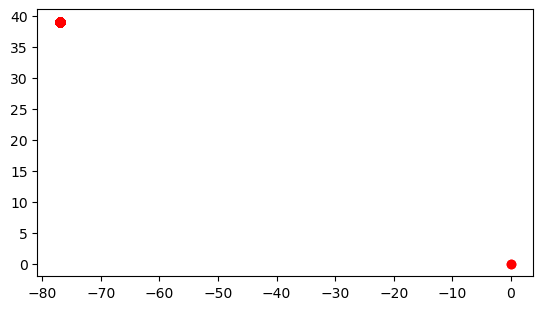

In [69]:
ax = cp.plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

Since some data seem to be out of the range, let's look at the coordinates sorted in descending order.

In [70]:
consolidated_data.sort_values(by='lon', ascending=False).head(5)

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
58,4,"3504 DePauw Place, College Park MD",American Holly,2023,fall,American Holly,H,S,2,0.736,7.340,0.000000,0.000000
175,3,"9224 Saint Andrew’s Pl, College Park MD",Tulip Tree,2024,fall,NaN,H,M,1,0.798,9.909,0.000000,0.000000
228,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
225,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
181,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614


### Clean coordinates

#### Check the missing lat/lon

In [71]:
depaw_index = consolidated_data.index[consolidated_data['lat'] == 0].tolist()

##### De Pauw Place

In [72]:
depauw_pl_3504 =  geolocator.geocode('3504 De Pauw Place, College Park MD', timeout=None)
depauw_pl_3504

Location(3504, De Pauw Place, Crystal Springs, College Park Woods, College Park, Prince George's County, Maryland, 20740, United States, (39.0065389, -76.9465289, 0.0))

In [73]:
depaw_lat = depauw_pl_3504.latitude
depaw_lon = depauw_pl_3504.longitude
consolidated_data.loc[depaw_index, 'lat'] = depaw_lat
consolidated_data.loc[depaw_index, 'lon'] = depaw_lon

In [74]:
consolidated_data.sort_values(by='lon', ascending=False).head(5)

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
228,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
225,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
215,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
181,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,fall,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
9,3,"5911 Bryn Mawr Rd, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736,12.845,38.984823,-76.911086


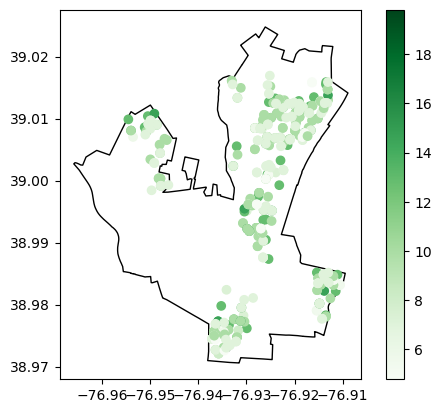

In [75]:
gdf = geopandas.GeoDataFrame(
    consolidated_data, geometry=geopandas.points_from_xy(consolidated_data.lon, consolidated_data.lat), crs="EPSG:4326"
)
ax = cp.plot(color="white", edgecolor="black")
# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='carbon_seq', cmap='Greens', legend=True)

plt.show()

In [76]:
consolidated_data.head()

,city_district,address,species,year,season,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,spring,NaN,H,M,2,0.736,12.845,39.007688,-76.917934
1,1,"5121 Kenesaw St, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845,39.007688,-76.917934
2,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845,39.010871,-76.923609
3,1,"4822 Erie Street, College Park MD",Willow Oak,2023,spring,Willow Oak,H,M,2,0.736,12.845,39.005966,-76.925937
4,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,spring,Southern Magnolia,H,M,2,0.736,12.845,39.012205,-76.919981


# Save consolidated data

In [77]:
len(consolidated_data)

368

In [78]:
consolidated_data.to_csv('consolidated_data.csv')